In [2]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import glob
from scipy import stats,signal

%matplotlib inline
%load_ext autoreload
%autoreload

from conv.general import *
import conv.neuralynx_io as nlxio
import neo

# remove all warnings:
import warnings
warnings.filterwarnings("ignore", message="Unable to parse")
warnings.filterwarnings("ignore", message="Invalid")


## load micro LFP from neuralynx

In [11]:

subid = "D567"
expid = "EXP9_Movie_24_Sleep"
dir_name = f"/Volumes/DATA/NLData/{subid}/{expid}/2023-08-23_00-54-56/combinedData"
file_names = sorted(glob.glob(f"{dir_name}/GA1*.ncs"))[:1]

lfp_mat = []
timestamps = []
for fn in file_names:
    print(fn)
    nlx_reader = nlxio.load_ncs(fn)
    # lfp_mat = superVstack(lfp_mat, nlx_reader['data']) # superVstack is a helper file in the general.py that John made
    timestamps = superVstack(timestamps, nlx_reader['time'])
    sr = nlx_reader['sampling_rate']
    print(f"Length of data: {len(nlx_reader['data'])/sr} seconds, sampling rate: {sr}")


/Volumes/DATA/NLData/D567/EXP9_Movie_24_Sleep/2023-08-23_00-54-56/combinedData/GA1-LA1.ncs
Length of data: 27580.8 seconds, sampling rate: 32000
/Volumes/DATA/NLData/D567/EXP9_Movie_24_Sleep/2023-08-23_00-54-56/combinedData/GA1-LA2.ncs
Length of data: 27580.8 seconds, sampling rate: 32000
/Volumes/DATA/NLData/D567/EXP9_Movie_24_Sleep/2023-08-23_00-54-56/combinedData/GA1-LA3.ncs
Length of data: 27580.8 seconds, sampling rate: 32000


## load micro LFP from neuralynx with neo:

In [18]:
subid = "D567"
expid = "EXP9_Movie_24_Sleep"
dir_name = "/Users/XinNiuAdmin/Documents/NWBTest/D567/EXP9_Movie_24_Sleep/2023-08-23_00-54-56/combinedData"

reader = neo.io.NeuralynxIO(
    dirname=dir_name, 
    # exclude_filename = ['LAC1.ncs', 'LAC2.ncs', 'LAC3.ncs'],
)
reader.parse_header()

In [ ]:
reader._nb_segments

In [ ]:
data = reader.read()

## Plot the interval between samples:



DD567, ExpEXP9_Movie_24_Sleep : sample rate difference: 0.07706016932570492 Hz




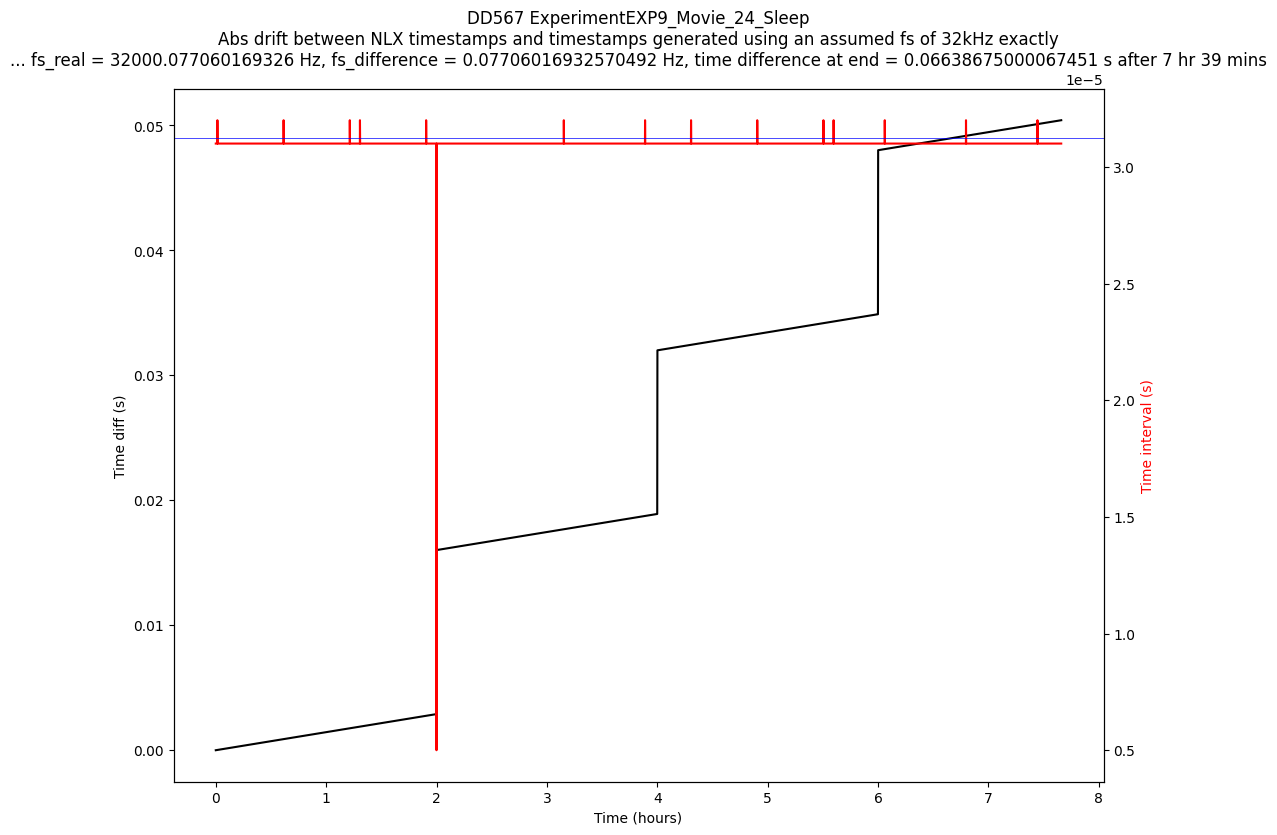

DD567 ExperimentEXP9_Movie_24_Sleep
Abs drift between NLX timestamps and timestamps generated using an assumed fs of 32kHz exactly
... fs_real = 32000.077060169326 Hz, fs_difference = 0.07706016932570492 Hz, time difference at end = 0.06638675000067451 s after 7 hr 39 mins
Difference in number of samples when generating timestamps with exactly 32kHz but precise time end: 2124




KeyboardInterrupt: 

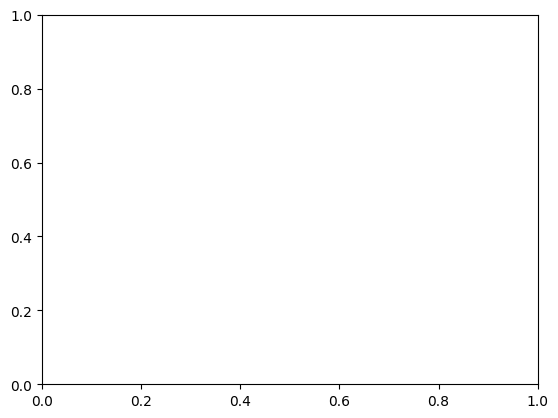

In [16]:

timestamp = timestamps[0]
timestamp = (timestamp - timestamp[0]) / 1e6  # seconds
nsamp = len(timestamp)
t_end = (timestamp[-1] - timestamp[0])  

fs_real = nsamp / t_end  # Hz

# compare this to the fs as reported by NLX
fs_reported = 32000  # Hz
fs_difference = abs(fs_real - fs_reported)

print(f'\n\nD{subid}, Exp{expid} : sample rate difference: {fs_difference} Hz\n\n')

# generate a time vector assuming a constant 32 kHz fs
time0 = 0
time_end = nsamp / fs_reported
time_steps = 1 / fs_reported
t_32k_exactly = np.arange(time0, time_end, time_steps)

# let's see the drift between the 2 time streams
ts_diff = np.abs(timestamp - t_32k_exactly)
ts_interval = np.hstack([np.abs(timestamp[1:] - timestamp[:-1]), np.nan])

# find the time in whole hours plus any extra minutes
t_end_hours = int(np.floor(t_end / (60 * 60)))
t_end_plus_mins = int((t_end / 60) - (t_end_hours * 60))

sub_sample = 100000
# plot the drift
plt.figure(figsize=(8, 6))

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(timestamp[::sub_sample] / (60 * 60), ts_diff[::sub_sample], 'k', label='Time diff (s)', linewidth=1.5)
ax2.plot(timestamp[::sub_sample] / (60 * 60), ts_interval[::sub_sample], 'r', label='Time interval (s)', linewidth=1.5)
ax2.axhline(y=1 / fs_reported, color='b', label='1/fs_reported', linewidth=0.5)

ax1.set_ylabel('Time diff (s)', color='k')
ax2.set_ylabel('Time interval (s)', color='r')
ax1.set_xlabel('Time (hours)')

plt.title(f'D{subid} Experiment{expid}\nAbs drift between NLX timestamps and timestamps generated using an assumed fs of 32kHz exactly\n'
          f' fs_real = {fs_real} Hz, fs_difference = {fs_difference} Hz\n'
          f'time difference at end = {np.abs(t_end - t_32k_exactly[-1])} s after {t_end_hours} hr {t_end_plus_mins} mins')

plt.show()

# but what if we use the accurate end time from the NLX
t_32k_accurate_tend = np.arange(0, t_end + 1 / 32000, 1 / 32000)
# the number of samples is now incorrect
nt = len(t_32k_accurate_tend)
n_ts_diff = abs(nsamp - nt)
print(f'Difference in number of samples when generating timestamps with exactly 32kHz but precise time end: {n_ts_diff}\n\n')

# histogram of the intervals between adjacent samples:
plt.figure()
plt.hist(ts_interval[::sub_sample], bins='auto', density=True)

# Add a vertical line at x = 0
plt.axvline(x=1 / fs_reported, color='r', linewidth=0.5)
plt.xlabel('interval (s)')
plt.ylabel('Frequency')
plt.title(f'Distribution of sample intervals: D{subid}, {expid}')
plt.show()
